# Character CNN CLassifier

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model, layers
import csv
import re
import pylab
import matplotlib.pyplot as plt

In [2]:
MAX_DOCUMENT_LENGTH = 100
N_FILTERS = 10
FILTER_SHAPE1 = [20, 256]
FILTER_SHAPE2 = [20, 1]
POOLING_WINDOW = 4
POOLING_STRIDE = 2
MAX_LABEL = 15

batch_size = 128
one_hot_size = 256
no_epochs = 100
lr = 0.01

seed = 10
tf.random.set_seed(seed)


## Read data

In [3]:
# Read data with [character]
def vocabulary(strings):
    chars = sorted(list(set(list(''.join(strings)))))
    char_to_ix = { ch:i for i,ch in enumerate(chars) }
    vocab_size = len(chars)
    return vocab_size, char_to_ix

In [4]:
def preprocess(strings, char_to_ix, MAX_LENGTH):
    data_chars = [list(d.lower()) for _, d in enumerate(strings)]
    for i, d in enumerate(data_chars):
        if len(d)>MAX_LENGTH:
            d = d[:MAX_LENGTH]
        elif len(d) < MAX_LENGTH:
            d += [' '] * (MAX_LENGTH - len(d))
            
    data_ids = np.zeros([len(data_chars), MAX_LENGTH], dtype=np.int64)
    for i in range(len(data_chars)):
        for j in range(MAX_LENGTH):
            data_ids[i, j] = char_to_ix[data_chars[i][j]]
    return np.array(data_ids)

In [5]:
def read_data_chars():
    x_train, y_train, x_test, y_test = [], [], [], []
    cop = re.compile("[^a-z^A-Z^0-9^,^.^' ']")
    with open('/content/drive/My Drive/tensorflow/train_medium.csv', encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            data = cop.sub("", row[1])
            x_train.append(data)
            y_train.append(int(row[0]))

    with open('/content/drive/My Drive/tensorflow/test_medium.csv', encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            data = cop.sub("", row[1])
            x_test.append(data)
            y_test.append(int(row[0]))

    vocab_size, char_to_ix = vocabulary(x_train+x_test)
    x_train = preprocess(x_train, char_to_ix, MAX_DOCUMENT_LENGTH)
    y_train = np.array(y_train)
    x_test = preprocess(x_test, char_to_ix, MAX_DOCUMENT_LENGTH)
    y_test = np.array(y_test)

    x_train = tf.constant(x_train, dtype=tf.int64)
    y_train = tf.constant(y_train, dtype=tf.int64)
    x_test = tf.constant(x_test, dtype=tf.int64)
    y_test = tf.constant(y_test, dtype=tf.int64)

    return x_train, y_train, x_test, y_test

In [6]:
x_train, y_train, x_test, y_test = read_data_chars()
# Use `tf.data` to batch and shuffle the dataset:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

## Build model

In [7]:
# Build model
tf.keras.backend.set_floatx('float32')
class CharCNN(Model):
    def __init__(self, vocab_size=256):
        super(CharCNN, self).__init__()
        self.vocab_size = vocab_size
        # Weight variables and RNN cell
        # Convolution layer C1, 10 filters of 20x256, VALID, ReLU
        self.conv1 = layers.Conv2D(N_FILTERS, FILTER_SHAPE1, padding='VALID', activation='relu', use_bias=True)
        # Pooling layer S1, 4x4 window size, stride=2
        self.pool1 = layers.MaxPool2D(POOLING_WINDOW, POOLING_STRIDE, padding='SAME')
        # Convolution layer C2, 10 filters of 20x1, VALID, ReLU
        self.conv2 = layers.Conv2D(N_FILTERS, FILTER_SHAPE2, padding='VALID', activation='relu', use_bias=True)
        # Pooling layer S2, 4x4 window size, stride=2
        self.pool2 = layers.MaxPool2D(POOLING_WINDOW, POOLING_STRIDE, padding='SAME')
        self.flatten = layers.Flatten()
        self.dense = layers.Dense(MAX_LABEL, activation='softmax')

    def call(self, x, drop_rate=0.5):
        # forward
        x = tf.one_hot(x, one_hot_size)
        x = x[..., tf.newaxis] 
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = tf.nn.dropout(x, drop_rate) 
        logits = self.dense(x)
        return logits

In [8]:
model = CharCNN(256)

# Choose optimizer and loss function for training
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=lr) #Adam 

# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')


## Functions for training and testing

In [9]:
# Training function
def train_step(model, x, label, drop_rate):
    with tf.GradientTape() as tape:
        out = model(x, drop_rate)
        loss = loss_object(label, out)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
    train_loss(loss)
    train_accuracy(labels, out)

In [10]:
# Testing function
def test_step(model, x, label, drop_rate=0):
    out = model(x,drop_rate)
    t_loss = loss_object(label, out)
    test_loss(t_loss)
    test_accuracy(label, out)

## Train model

In [11]:
test_acc = []
train_lo = []
for epoch in range(no_epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(model, images, labels, drop_rate=0.5)

    for images, labels in test_ds:
        test_step(model, images, labels, drop_rate=0)

    test_acc.append(test_accuracy.result())
    train_lo.append(train_loss.result())
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print (template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result(),
                          test_loss.result(),
                          test_accuracy.result()))

Epoch 1, Loss: 2.3261594772338867, Accuracy: 0.20196428894996643, Test Loss: 1.7988682985305786, Test Accuracy: 0.38999998569488525
Epoch 2, Loss: 1.5627026557922363, Accuracy: 0.4494642913341522, Test Loss: 1.2848336696624756, Test Accuracy: 0.5628571510314941
Epoch 3, Loss: 1.1660128831863403, Accuracy: 0.585357129573822, Test Loss: 1.1300081014633179, Test Accuracy: 0.6200000047683716
Epoch 4, Loss: 0.9696000814437866, Accuracy: 0.6600000262260437, Test Loss: 1.0621157884597778, Test Accuracy: 0.6485714316368103
Epoch 5, Loss: 0.8424000144004822, Accuracy: 0.7046428322792053, Test Loss: 1.0382766723632812, Test Accuracy: 0.6728571653366089
Epoch 6, Loss: 0.745890200138092, Accuracy: 0.731071412563324, Test Loss: 1.038164496421814, Test Accuracy: 0.6642857193946838
Epoch 7, Loss: 0.6986073851585388, Accuracy: 0.7558928728103638, Test Loss: 1.0371896028518677, Test Accuracy: 0.6957142949104309
Epoch 8, Loss: 0.6162469387054443, Accuracy: 0.7855356931686401, Test Loss: 1.12979269027709

## Plot accuracy and loss curves

Text(0, 0.5, 'Train Loss')

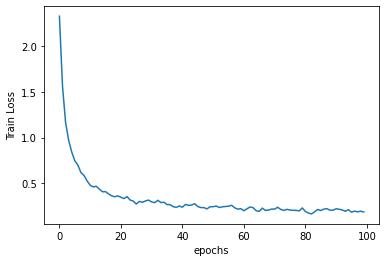

In [12]:
# Plot train loss
pylab.figure()
pylab.plot(np.arange(no_epochs), train_lo)
pylab.xlabel('epochs')
pylab.ylabel('Train Loss')

Text(0, 0.5, 'Test Accuracy')

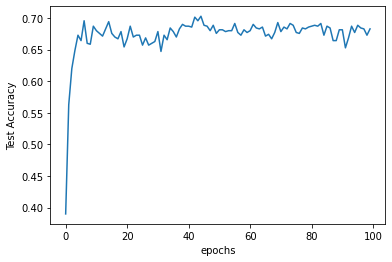

In [13]:
# Plot test accuracy
pylab.figure()
pylab.plot(np.arange(no_epochs), test_acc)
pylab.xlabel('epochs')
pylab.ylabel('Test Accuracy')